In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import random
import time
from simitate_dataset import SimitateTrajectoriesDataset
import matplotlib
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

In [2]:
# load the simitate data as a pytorch compatible dataset. 
# Will be automatically download in case not existing

# simitate_data = SimitateTrajectoriesDataset(".", download=True)
simitate_data = SimitateTrajectoriesDataset(".", download=True, categories=["basic_motions"])
# print(simitate_data)

Files already downloaded and verified


/home/raphael/git/pytorch_learning_repo/trajectory_loader.py:118: UserWarning: Warning! No transformation in world found
  warnings.warn("Warning! No transformation in world found")


Categories: ['motions', 'basic_motions', 'complex', 'sequential']
Classes: ['circle', 'rect', 'triangle', 'heart', 'zickzack']
Perons: ['raphael', 'jasmin', 'ivanna', 'andrea', 'quintas', 'oscar', 'raphael', 'jasmin', 'ivanna', 'andrea', 'quintas', 'oscar', 'raphael', 'ivanna', 'andrea', 'quintas', 'oscar', 'raphael', 'jasmin', 'ivanna', 'andrea', 'quintas', 'oscar', 'raphael', 'jasmin', 'ivanna', 'andrea', 'quintas', 'oscar']
Trajectories: ['circle_2018-09-15-19-00-09.csv', 'circle_2018-09-15-18-59-45.csv', 'circle_2018-09-15-19-00-21.csv', 'circle_2018-09-15-18-59-57.csv', 'circle_2018-09-15-18-59-33.csv', 'circle_2018-09-15-19-08-36.csv', 'circle_2018-09-15-19-08-49.csv', 'circle_2018-09-15-19-09-49.csv', 'circle_2018-09-15-19-09-01.csv', 'circle_2018-09-15-19-09-37.csv', 'circle_2018-09-15-19-08-24.csv', 'circle_2018-09-15-19-09-25.csv', 'circle_2018-09-15-19-10-01.csv', 'circle_2018-09-15-19-09-13.csv', 'circle_2018-09-15-19-08-12.csv', 'circle_2018-09-17-22-00-41.csv', 'circle_20

In [3]:
simitate_data.trajectory_data[0]["trajectory"][:,1:]
len()

TypeError: len() takes exactly one argument (0 given)

In [4]:
# TODO: removing open pose estimation

len(simitate_data.trajectories)
for x in range(simitate_data.trajectories.count("openpose.csv")):
    simitate_data.trajectories.remove("openpose.csv")
len(simitate_data.trajectories)

325

126


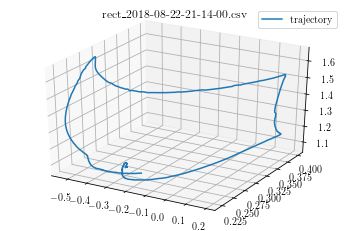

178


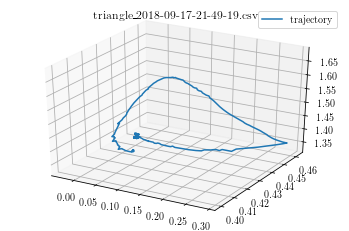

160


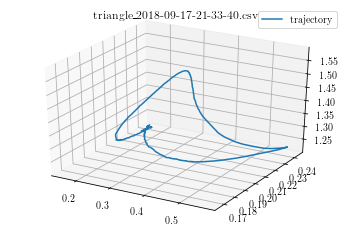

64


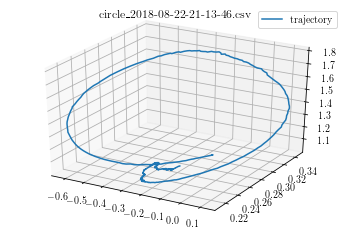

20


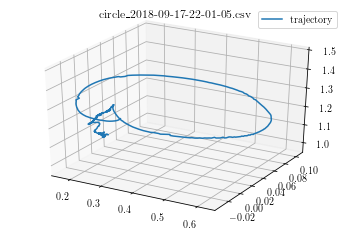

211


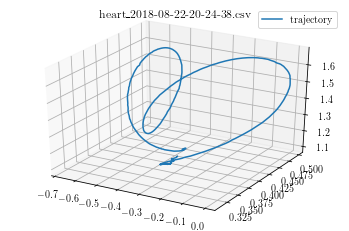

130


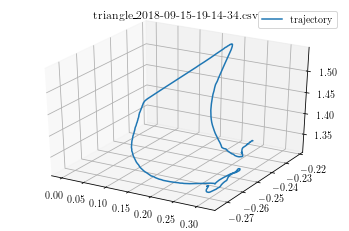

88


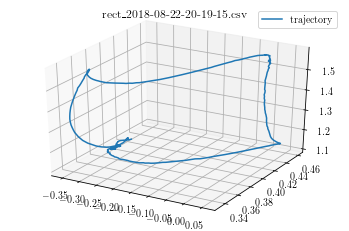

287


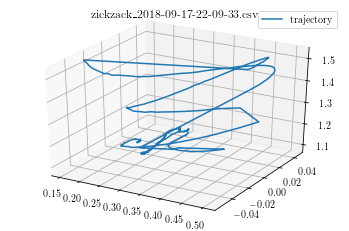

20


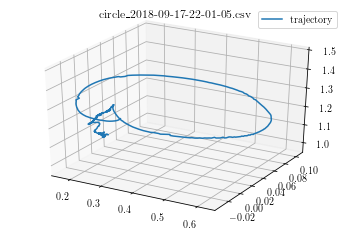

In [5]:
# Randomly sample some trajectories for visualualization
# and plot them

for i in range(10): 
    data_sample = random.choice(range(len(simitate_data.trajectory_data)))
    print(data_sample)
    simitate_data.plot(data_sample)

In [6]:
t = time.time()
timestr = time.strftime("%b_%d_%Y_%H:%M:%S", time.gmtime(t))
# default `log_dir` is "runs" - we'll be more specific here
log = 'runs/test_simitate_'+timestr
writer = SummaryWriter(log)
log

'runs/test_simitate_Oct_08_2019_11:52:37'

In [7]:
#simitate_data.trajectory_data[0]["trajectory"]

In [8]:
max_trajectory_length = 0
min_trajectory_length = 999

for i in range(len(simitate_data)):
    sample = simitate_data[i][0]
#     print("Data for trajectory %d, %s, %d" % (i, sample, len(sample)))
    if max_trajectory_length < len(sample):
        max_trajectory_length = len(sample)
    if min_trajectory_length > len(sample):
        min_trajectory_length = len(sample)

print(max_trajectory_length)
print(min_trajectory_length)
#     if i == 2:
#         break


836
359


In [9]:
# Trim to the shortest sequence
for i in range(len(simitate_data)):
    simitate_data.trajectory_data[i]["trajectory"] = simitate_data.trajectory_data[i]["trajectory"][:min_trajectory_length]
#     print(len(simitate_data.trajectory_data[i]["trajectory"]))
# print(simitate_data.trajectory_data)

In [10]:

batch_size = 100
simitate_loader = data.DataLoader(simitate_data, batch_size=batch_size, num_workers=0)


In [11]:

# We build a simple model with the inputs and one output layer.
class my_model(nn.Module):
    def __init__(self,n_in=2,n_hidden=10,n_out=4):
        super(my_model,self).__init__()
        self.n_in = n_in
        self.linear1 = nn.Linear(n_in, n_hidden,bias=True)   # Hidden layer.
        self.linear2 = nn.Linear(n_hidden, n_out, bias=True)
        self.logprob = nn.LogSoftmax(dim=1)                 # -Log(Softmax probability).
    
    def forward(self,x):
#         print("0", x.shape)
        x = x.view(-1, self.n_in)
        x = self.linear1(x)
#         print("1", x.shape)
        x = self.linear2(x)
#         print("2", x.shape)
        x = self.logprob(x)
#         print("3", x.shape)
        return x

# Model.
print(min_trajectory_length*3)
model = my_model(n_in=min_trajectory_length*3, n_hidden=100, n_out=len(simitate_data.classes))

1077


In [12]:
simitate_data.classes

['circle', 'rect', 'triangle', 'heart', 'zickzack']

In [13]:
# Negative log likelihood loss.
criterium = nn.NLLLoss()

# Adam optimizer with learning rate 0.1 and L2 regularization with weight 1e-4.
optimizer = torch.optim.Adam(model.parameters(),lr=0.1,weight_decay=1e-4)


In [14]:
# Taining.
for a, (target, trajectory_data) in enumerate(simitate_loader):
    print("aaaa", target, trajectory_data)

aaaa tensor([[[ 0.0581,  0.5396,  0.7911],
         [ 0.0581,  0.5396,  0.7911],
         [ 0.0581,  0.5396,  0.7911],
         ...,
         [ 0.5796,  0.3616,  1.1627],
         [ 0.5762,  0.3629,  1.1563],
         [ 0.5728,  0.3644,  1.1499]],

        [[ 0.0613,  0.4726,  0.8034],
         [ 0.0615,  0.4724,  0.8035],
         [ 0.0614,  0.4724,  0.8037],
         ...,
         [-0.3238,  0.3896,  1.5628],
         [-0.3213,  0.3870,  1.5704],
         [-0.3185,  0.3889,  1.5771]],

        [[ 0.0364,  0.5020,  0.8053],
         [ 0.0364,  0.5020,  0.8053],
         [ 0.0365,  0.5020,  0.8053],
         ...,
         [ 0.5382,  0.3251,  1.2142],
         [ 0.5339,  0.3271,  1.2070],
         [ 0.5296,  0.3290,  1.1999]],

        ...,

        [[ 0.2433,  0.0110,  1.1522],
         [ 0.2433,  0.0109,  1.1522],
         [ 0.2433,  0.0109,  1.1520],
         ...,
         [ 0.3785, -0.0176,  1.3719],
         [ 0.3711, -0.0178,  1.3720],
         [ 0.3638, -0.0182,  1.3720]],

     

In [14]:
running_loss = 0.0
for epoch in range(1000000):
    for k, (trajectory_data, target) in enumerate(simitate_loader):
        # Definition of inputs as variables for the net.
        # requires_grad is set False because we do not need to compute the 
        # derivative of the inputs.
        data_var   = Variable(trajectory_data,requires_grad=False)
        target_var = Variable(target.long(),requires_grad=False)

        # Set gradient to 0.
        optimizer.zero_grad()
        # Feed forward.
        pred = model(data_var)
        # Loss calculation.
        loss = criterium(pred,target_var.view(-1))
        # Gradient calculation.
        loss.backward()

        # Print loss every 10 iterations.
        if (epoch%100==0):
            print('Epoch {:d} Loss {:.4f} at iter {:d}'.format(epoch,loss.item(),k))
            writer.add_scalar('training loss',
                running_loss / 1000,
                epoch * len(simitate_loader) + i)

        # Model weight modification based on the optimizer. 
        optimizer.step()
        
                # ...log the running loss
        running_loss += loss.item()

    running_loss = 0.0

#         # ...log a Matplotlib Figure showing the model's predictions on a
#         # random mini-batch
#         writer.add_figure('predictions vs. actuals',
#                         plot_classes_preds(net, inputs, labels),
#                         global_step=epoch * len(simitate_loader) + i)
        

Epoch 0 Loss 1.5016 at iter 0
Epoch 0 Loss 291.1882 at iter 1
Epoch 0 Loss 65.1977 at iter 2
Epoch 0 Loss 0.0000 at iter 3
Epoch 100 Loss 1.8099 at iter 0
Epoch 100 Loss 1.4276 at iter 1
Epoch 100 Loss 1.4640 at iter 2
Epoch 100 Loss 0.6065 at iter 3
Epoch 200 Loss 960.9673 at iter 0
Epoch 200 Loss 1330.8597 at iter 1
Epoch 200 Loss 1678.9771 at iter 2
Epoch 200 Loss 563.8901 at iter 3
Epoch 300 Loss 1.5275 at iter 0
Epoch 300 Loss 1.5036 at iter 1
Epoch 300 Loss 1.4233 at iter 2
Epoch 300 Loss 0.4822 at iter 3
Epoch 400 Loss 1.6670 at iter 0
Epoch 400 Loss 1.2988 at iter 1
Epoch 400 Loss 1.5123 at iter 2
Epoch 400 Loss 0.5181 at iter 3
Epoch 500 Loss 1.6616 at iter 0
Epoch 500 Loss 1.3470 at iter 1
Epoch 500 Loss 1.4736 at iter 2
Epoch 500 Loss 0.5775 at iter 3
Epoch 600 Loss 1.5670 at iter 0
Epoch 600 Loss 1.3951 at iter 1
Epoch 600 Loss 1.4566 at iter 2
Epoch 600 Loss 0.4164 at iter 3
Epoch 700 Loss 8.6277 at iter 0
Epoch 700 Loss 3.5057 at iter 1
Epoch 700 Loss 7.4533 at iter 2
Epo

KeyboardInterrupt: 